## **i. Mount google drive**
---

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **ii. Import the libraries**
---

In [2]:
import cv2
import sys
import os
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

print("Versions of key libraries")
print("---")
print("cv2:       ", cv2.__version__)
print("numpy:     ", np.__version__)
print("matplotlib:", matplotlib.__version__)
print("pandas.   :", pd.__version__)


Versions of key libraries
---
cv2:        4.1.2
numpy:      1.19.5
matplotlib: 3.2.2
pandas.   : 1.1.5


## **iii. Append /iss/vse/data/ in your python path**
---

In [3]:
sys.path.append('/content/gdrive/My Drive/iss/vse/data/')
print("All the system paths:")
sys.path

All the system paths:


['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/My Drive/iss/vse/data/']

## **iv. Change working directory to /iss/vse/data/**
---

In [4]:
os.chdir('/content/gdrive/My Drive/iss/vse/data/')
print("Current working directory:")
os.getcwd()

Current working directory:


'/content/gdrive/My Drive/iss/vse/data'

## **v. Define `cv2plt` for image display**
---

In [5]:
def cv2plt(img):
    plt.figure(figsize=(8,8))        # To change the size of figure
    plt.axis('off')
    if np.size(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(img,cmap='gray',vmin=0,vmax=255)  
    plt.show()

print(cv2plt)

<function cv2plt at 0x7fb5741dae60>


## **1. Load image of interest**
---
Load `normal.png` to `nrm`. Extract only the green channel, assigned to `nrmg`. Plot the output

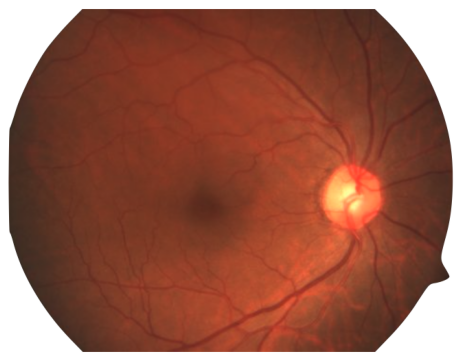

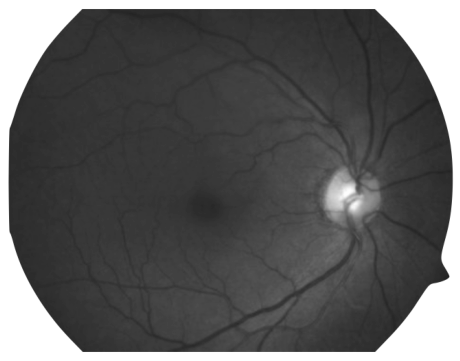

In [6]:
nrm  = cv2.imread('normal.png')
nrmg = nrm[:,:,1]

cv2plt(nrm)
cv2plt(nrmg)

---
Load `diabetic retinopathy.png` to `dbr`. Extract only the green channel, assigned to `dbrg`. Plot the output

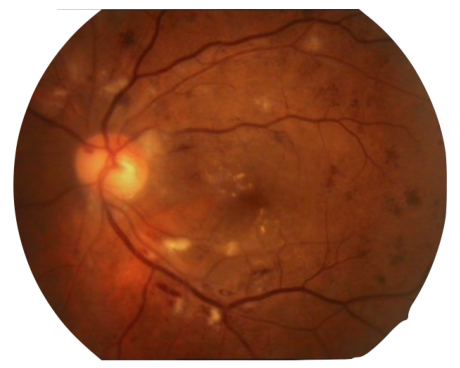

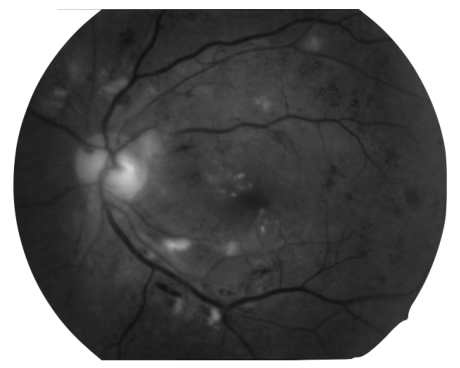

In [7]:
dbr  = cv2.imread('diabetic retinopathy.png')
dbrg = dbr[:,:,1]

cv2plt(dbr)
cv2plt(dbrg)

## **2. Isolate the retina region**
---
In this first attempt, the code is going to create a mask and isolate retina region on normal image.

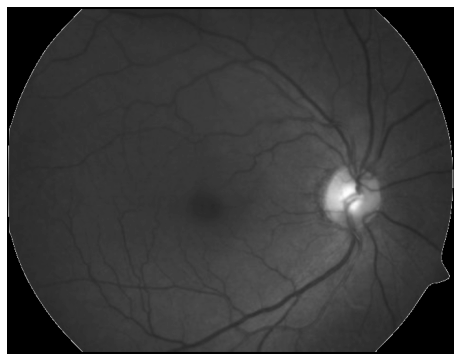

In [8]:
(_,mask)= cv2.threshold(nrmg,
                        254,
                        255,
                        cv2.THRESH_BINARY)
dmask   = 255-mask
nrmgc   = cv2.bitwise_and(nrmg,
                          nrmg,
                          mask=dmask)
cv2plt(nrmgc)


In the output, we can see a white line enclosing the retina region. This white line can cause problem in later processing. So in the second attempt, we shall dilate the mask with the default kernel 3 x 3 and isolate the retina region


---

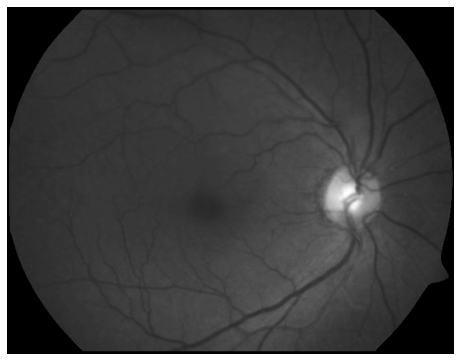

In [9]:
(_,mask)= cv2.threshold(nrmg,
                        254,
                        255,
                        cv2.THRESH_BINARY)
dmask   = cv2.dilate(mask,
                     None,
                     1)
dmask   = 255-dmask
nrmgc   = cv2.bitwise_and(nrmg,
                          nrmg,
                          mask=dmask)
cv2plt(nrmgc)

The same steps can be also applied on `dbrg`, the diabetic retinopathy image

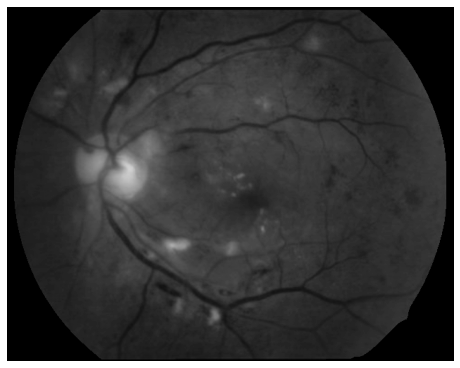

In [10]:
(_,mask)= cv2.threshold(dbrg,
                        254,
                        255,
                        cv2.THRESH_BINARY)
dmask   = cv2.dilate(mask,
                     None,
                     1)
dmask   = 255-dmask
dbrgc   = cv2.bitwise_and(dbrg,
                          dbrg,
                          mask=dmask)
cv2plt(dbrgc)

## **3. Strengthen features**
---
Before we can extract useful features, one of the things we can do is to strengthen the features in each image. We can get things stand out by increasing the contrast. At here, we are going to apply `CLAHE` on the two images

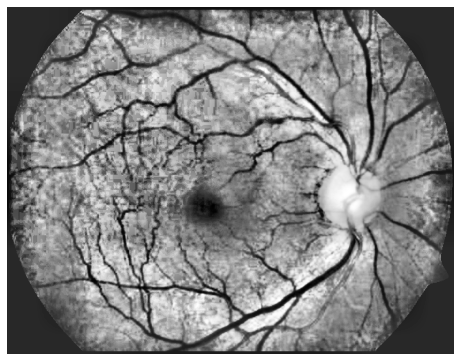

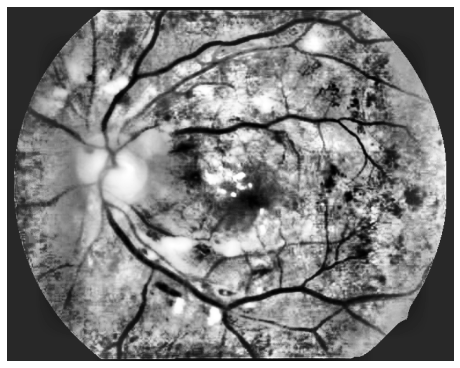

In [11]:
clahe     = cv2.createCLAHE()

nrmge     = clahe.apply(nrmgc)
dbrge     = clahe.apply(dbrgc)

cv2plt(nrmge)
cv2plt(dbrge)

## **4. Reduce noise**
---
From the outputs,  we can see noise is prevalent in both normal and diabetic images. To reduce the noise, simply use mean filtering.

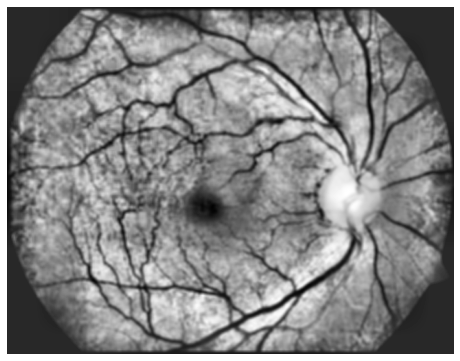

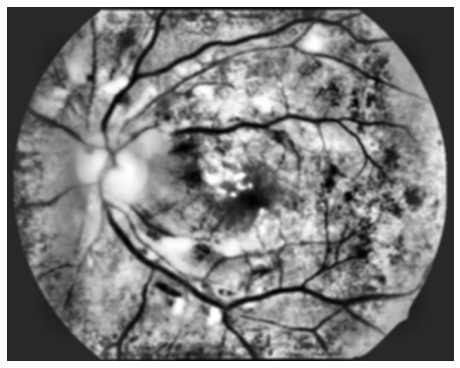

In [12]:
nrmgb     = cv2.blur(nrmge,
                     (5,5))
dbrgb     = cv2.blur(dbrge,
                     (5,5))

cv2plt(nrmgb)
cv2plt(dbrgb)

## **5. Preliminary feature extraction**
---
After noise reduction, let's apply simple thresholding to see if we can capture features in both images that could separate the two. From observation, most likely the dark areas in both images are more useful for differentation. In the thresholding, we want these dark areas to be retained, to do that, we invert the image by taking 255 minus the image of interest, and then use this output for thresholding.

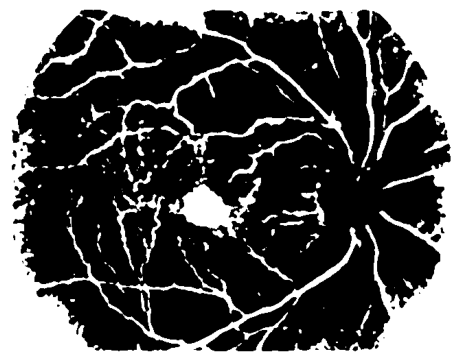

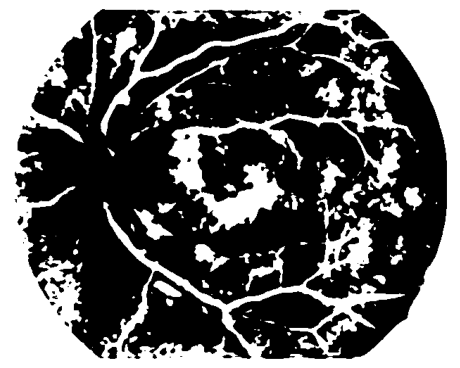

In [13]:
(_,nrmgt) = cv2.threshold(255-nrmgb,             # This is to invert the image
                          160,
                          255,
                          cv2.THRESH_BINARY)
(_,dbrgt) = cv2.threshold(255-dbrgb,
                          160,
                          255,
                          cv2.THRESH_BINARY)

cv2plt(nrmgt)
cv2plt(dbrgt)

## **6. Feature reduction**
---
The strategy works. But there are features such as blood vessels included in the outputs. To remove those features, we apply morphological operations

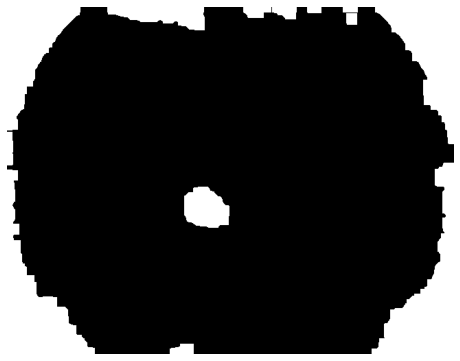

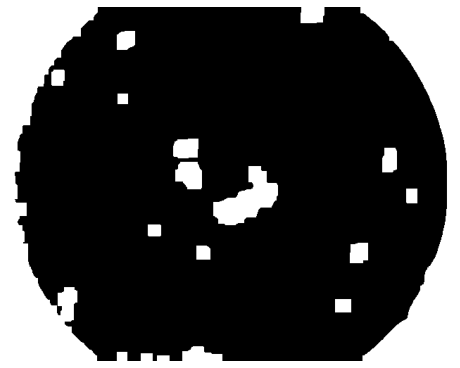

In [14]:
nrmgf     = cv2.morphologyEx(nrmgt,
                             cv2.MORPH_OPEN,
                             np.ones((15,15), np.uint8))
dbrgf     = cv2.morphologyEx(dbrgt,
                             cv2.MORPH_OPEN,
                             np.ones((15,15), np.uint8))

cv2plt(nrmgf)
cv2plt(dbrgf)

## **7. Extract boundaries**
---
The outputs are clean, but the enclosing boundaries in both images are still present. We can apply `findContour` to locate the boundaries, and draw the contours filled with `0` value. This will allow us to create a mask that retain only features that matter.

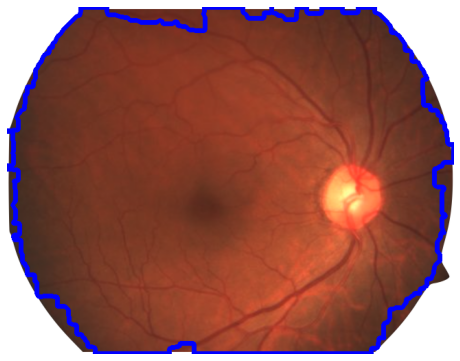

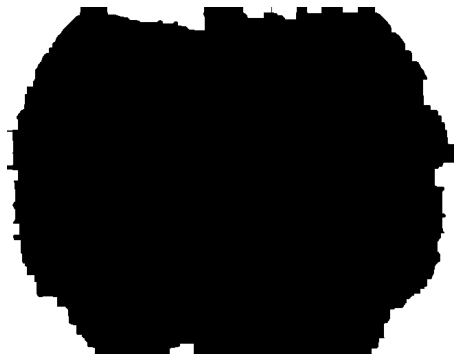

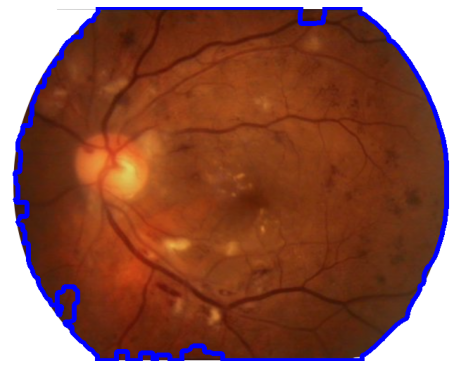

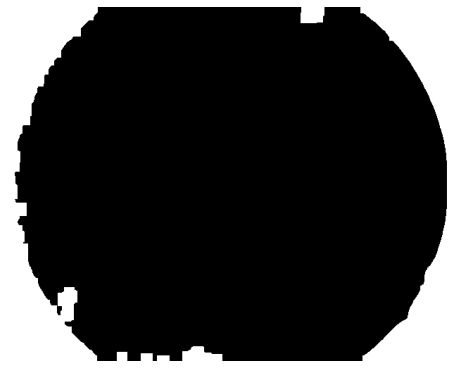

In [15]:
                            # Normal
                            # ----------

ctrs      = cv2.findContours(255-nrmgf,
                             cv2.RETR_EXTERNAL,
                             cv2.CHAIN_APPROX_SIMPLE)
ctrs      = ctrs[0]
nrg_c     = nrm.copy()

cv2.drawContours(nrg_c,     # Draw the located contours on colour image for inspection
                 ctrs,
                 -1,
                  (255,0,0),
                  5)
cv2plt(nrg_c)               # Plot the contoured image


                            # -----------

fmasknrm  = nrmgf.copy()
cv2.drawContours(fmasknrm,
                 ctrs,
                 -1,
                 0,
                 cv2.FILLED)

cv2plt(fmasknrm)            # Show the mask


# -----------------------------------------

                            # Diabetic
                            # -----------
ctrsdbr   = cv2.findContours(255-dbrgf,
                             cv2.RETR_EXTERNAL,
                             cv2.CHAIN_APPROX_SIMPLE)
ctrsdbr   = ctrsdbr[0]
dbr_c     = dbr.copy()

cv2.drawContours(dbr_c,
                 ctrsdbr,
                 -1,
                  (255,0,0),
                  5)
cv2plt(dbr_c)


                            # -----------

fmaskdbr  = dbrgf.copy()
cv2.drawContours(fmaskdbr,
                 ctrsdbr,
                 -1,
                 0,
                 cv2.FILLED)

cv2plt(fmaskdbr)


## **8. Final features**
---
The features are extracted by isolating features within the retinal region, removing any boundary information.

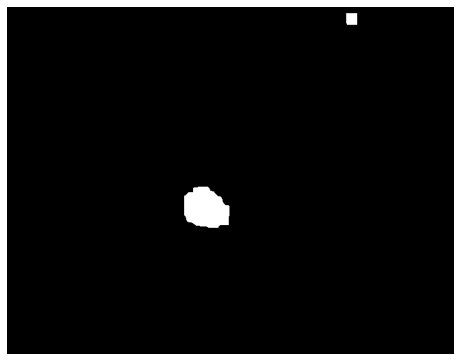

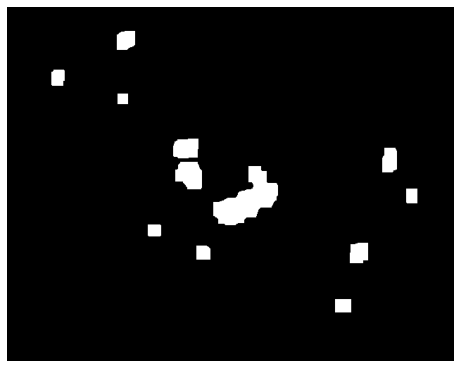

In [16]:
normFeatures  = cv2.bitwise_and(nrmgf,
                                nrmgf,
                                mask=255-fmasknrm)

dbrFeatures  = cv2.bitwise_and(dbrgf,
                               dbrgf,
                               mask=255-fmaskdbr)
                                    # The inversion is required because in the mask, the
                                    # retinal region has value 0, not 255

cv2plt(normFeatures)
cv2plt(dbrFeatures)